#Imports

In [23]:
from google.colab import drive 
drive.mount('/content/drive',)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import matplotlib.pyplot as plt

In [25]:
# Define hyperparameters
#batch_size = 64
batch_size = 32
learning_rate = 0.001
num_epochs = 60
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dataset class
class PlumeDataset(Dataset):
    def __init__(self, plume_dir, no_plume_dir, transform=None):
        self.plume_images = [os.path.join(plume_dir, img) for img in os.listdir(plume_dir)]
        self.no_plume_images = [os.path.join(no_plume_dir, img) for img in os.listdir(no_plume_dir)]
        self.images = self.plume_images + self.no_plume_images
        self.targets = [1] * len(self.plume_images) + [0] * len(self.no_plume_images)
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('L')
        target = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        return image, target

# Define data transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])




#Dataloaders

The original dataset contained 214 images containing a methane plume, and 214 images not containing a methane plume. Now, to train our model we created four additional folders. The plume_training folders contain 192 images containg a methane plume and the no_plume_training folder has 192 images not containing a methane plume. The plume_testing folders contain 22 images containg a methane plume and the no_plume_testing folder contains 22 images not containing a methane plume selected manually at random.

In [26]:
# Create datasets and dataloaders
train_dataset = PlumeDataset('/content/drive/MyDrive/QB/plume_training', '/content/drive/MyDrive/QB/no_plume_training', transform=train_transforms)
test_dataset = PlumeDataset('/content/drive/MyDrive/QB/plume_testing', '/content/drive/MyDrive/QB/no_plume_testing', transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define CNN model
class PlumeCNN(nn.Module):
    def __init__(self):
        super(PlumeCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.pool(self.bn1(nn.functional.relu(self.conv1(x))))
        x = self.pool(self.bn2(nn.functional.relu(self.conv2(x))))
        x = x.view(-1, 64 * 16 * 16)
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = nn.functional.sigmoid(self.fc2(x))
        return x




In [27]:
# Initialize model and optimizer
model = PlumeCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
def evaluate(model, loader):
    model.eval()
    targets = []
    #Obtain a list of prediction scores. If the prediction score >= 0.5, it means the image contains a plume, else not
    predictions = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images).squeeze()
            predictions += outputs.cpu().tolist()
            targets += labels.cpu().tolist()
    #accuracy = np.mean(np.array(predictions) > 0.5) * 100
    accuracy = accuracy_score(targets, [round(p) for p in predictions])
    auc_score = roc_auc_score(targets, predictions) * 100
    return accuracy, auc_score


#Training the model and get test accuracy and AUC score

In [29]:
import matplotlib.pyplot as plt

# Lists to store the loss and AUC scores
train_losses = []
test_losses = []
auc_scores = []
test_acc = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    test_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_dataset)
    test_accuracy, test_auc_score = evaluate(model, test_loader)
    
    # Store the loss and AUC score for plotting
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    auc_scores.append(test_auc_score)
    test_acc.append(test_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.2f}, Test AUC: {test_auc_score:.2f}%")



Epoch 1/60, Train Loss: 1.5068, Test Accuracy: 0.61, Test AUC: 69.42%
Epoch 2/60, Train Loss: 0.7322, Test Accuracy: 0.64, Test AUC: 69.21%
Epoch 3/60, Train Loss: 0.6806, Test Accuracy: 0.61, Test AUC: 63.02%
Epoch 4/60, Train Loss: 0.6135, Test Accuracy: 0.70, Test AUC: 70.87%
Epoch 5/60, Train Loss: 0.5925, Test Accuracy: 0.64, Test AUC: 76.45%
Epoch 6/60, Train Loss: 0.5767, Test Accuracy: 0.73, Test AUC: 76.03%
Epoch 7/60, Train Loss: 0.5537, Test Accuracy: 0.70, Test AUC: 77.89%
Epoch 8/60, Train Loss: 0.6048, Test Accuracy: 0.70, Test AUC: 76.24%
Epoch 9/60, Train Loss: 0.5415, Test Accuracy: 0.64, Test AUC: 71.90%
Epoch 10/60, Train Loss: 0.5664, Test Accuracy: 0.73, Test AUC: 77.07%
Epoch 11/60, Train Loss: 0.5361, Test Accuracy: 0.66, Test AUC: 77.07%
Epoch 12/60, Train Loss: 0.5581, Test Accuracy: 0.75, Test AUC: 84.30%
Epoch 13/60, Train Loss: 0.5531, Test Accuracy: 0.68, Test AUC: 82.64%
Epoch 14/60, Train Loss: 0.5157, Test Accuracy: 0.77, Test AUC: 81.82%
Epoch 15/60, Tr

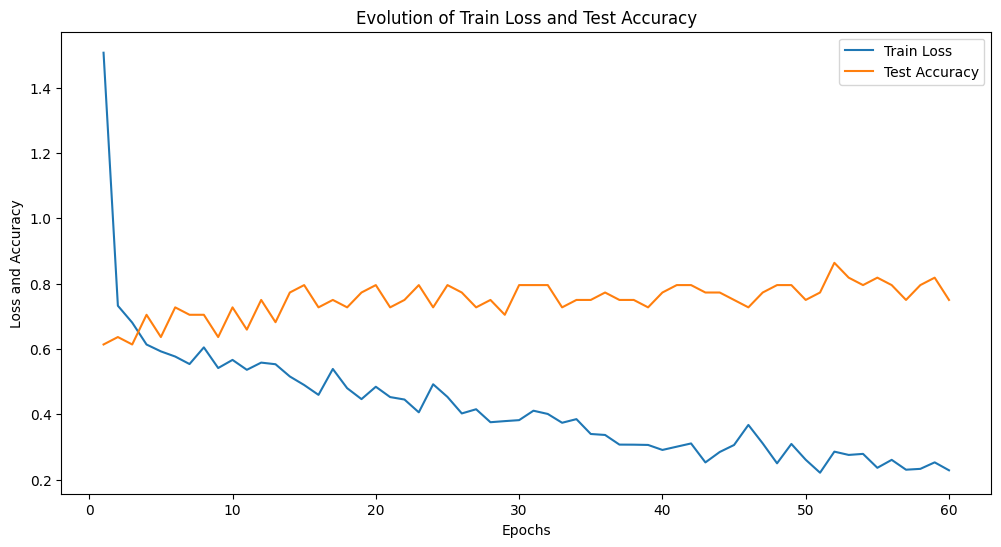

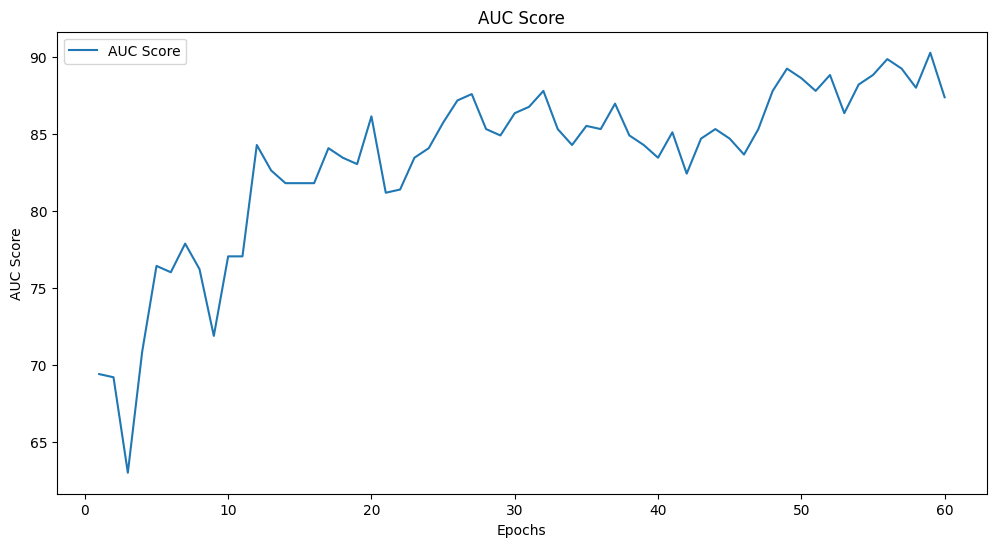

In [30]:
# Plotting the training loss and test loss
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss and Accuracy')
plt.title('Evolution of Train Loss and Test Accuracy')
plt.legend()
plt.show()

# Plotting the AUC score
plt.figure(figsize=(12, 6))
plt.plot(epochs, auc_scores, label='AUC Score')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.title('AUC Score')
plt.legend()
plt.show()

In [31]:
best_model_path = "/content/drive/MyDrive/QB/models/model_Epoch_50_AUC_90.pt"
torch.save(model.state_dict(), best_model_path)

#Upload a folder and getting classification score

In [67]:
# Define dataset class
class ValidationDataset(Dataset):
    def __init__(self, val_dir, transform=None):
        #self.plume_images = [os.path.join(plume_dir, img) for img in os.listdir(plume_dir)]
        self.val_dir = [os.path.join(val_dir, img) for img in os.listdir(val_dir)]
        self.images = self.val_dir
        #self.targets = [1] * len(self.plume_images) + [0] * len(self.no_plume_images)
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('L')
        #target = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        return image
# Define data transforms


test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])






In [85]:
val_dataset = ValidationDataset('/content/drive/MyDrive/QB/plume_testing',  transform=test_transforms)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Load the saved model
model = PlumeCNN()
model.load_state_dict(torch.load("/content/drive/MyDrive/QB/models/model_Epoch_50_AUC_90.pt"))
# Move the model to the same device as the input tensor
model.to(device)
model.eval()

# Iterate over each image in the folder
for images in val_loader:
    images = images.to(device)

    # If sigmoid_output >= 0.5, then positive, else negative
    output = model(images).squeeze()
    print("Output:")
    print(output)

    #sigmoid_output = torch.sigmoid(output)
    #print("Sigmoid output:")
    #print(sigmoid_output)

    predictions = torch.round(output)
    print("Predictions:")
    print(predictions)

    # Print the predicted classification result for each image
    for i in range(len(predictions)):
        print(f'The image {i+1} is classified as {"Positive" if predictions[i]==1 else "Negative"}.')
        print(f'Prediction score: {output[i].item():.4f}')
        print()



Output:
tensor([0.9997, 0.9960, 0.8942, 0.9969, 0.0580, 1.0000, 0.0857, 0.9999, 1.0000,
        0.9208, 0.0998, 0.9998, 0.9708, 0.9085, 0.9658, 0.3861, 0.9438, 0.9600,
        1.0000, 0.3472, 0.4151, 0.9585], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
Predictions:
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 0., 1.], device='cuda:0', grad_fn=<RoundBackward0>)
The image 1 is classified as Positive.
Prediction score: 0.9997

The image 2 is classified as Positive.
Prediction score: 0.9960

The image 3 is classified as Positive.
Prediction score: 0.8942

The image 4 is classified as Positive.
Prediction score: 0.9969

The image 5 is classified as Negative.
Prediction score: 0.0580

The image 6 is classified as Positive.
Prediction score: 1.0000

The image 7 is classified as Negative.
Prediction score: 0.0857

The image 8 is classified as Positive.
Prediction score: 0.9999

The image 9 is classified as Positive.
Prediction score: 1

#Upload one image and get the classification score

In [92]:
image_path = '/content/20230126_methane_mixing_ratio_id_4456.tif'
destination_empty_directory = "/content/drive/MyDrive/QB/empty_directory"

# Create the destination directory if it doesn't exist
os.makedirs(destination_empty_directory, exist_ok=True)

# Copy the image to the destination directory
shutil.copy2(image_path, destination_empty_directory)

val_dataset = ValidationDataset(destination_empty_directory,  transform=test_transforms)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [93]:
# Load the saved model
model = PlumeCNN()
model.load_state_dict(torch.load("/content/drive/MyDrive/QB/models/model_Epoch_50_AUC_90.pt"))
# Move the model to the same device as the input tensor
model.to(device)
model.eval()

# Iterate over each image in the folder
for images in val_loader:
    images = images.to(device)

    # If sigmoid_output >= 0.5, then positive, else negative
    output = model(images).squeeze()
    print("Output:")
    print(output)

    predictions = torch.round(output)
    print("Predictions:")
    print(predictions.item())  # Convert to Python scalar

    # Print the classification result for the image
    print(f'The image is classified as {"Positive" if predictions.item()==1 else "Negative"}.')
    print(f'Prediction score: {output.item():.4f}')
    print()




Output:
tensor(0.0006, device='cuda:0', grad_fn=<SqueezeBackward0>)
Predictions:
0.0
The image is classified as Negative.
Prediction score: 0.0006



In [94]:
#Delete the image from the empty directory folder
# Get the list of files in the folder
files = os.listdir(destination_empty_directory)

# Iterate over the files and delete each one
for file in files:
    file_path = os.path.join(destination_empty_directory, file)
    if os.path.isfile(file_path):
        os.remove(file_path)

#Developing a web app to display the results

In [36]:
!pip install -q streamlit

In [37]:
from PIL import Image

In [38]:
%%writefile app.py
import streamlit as st
from PIL import Image

from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt


last_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

batch_size = 32
learning_rate = 0.001
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PlumeCNN(nn.Module):
    def __init__(self):
        super(PlumeCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.pool(self.bn1(nn.functional.relu(self.conv1(x))))
        x = self.pool(self.bn2(nn.functional.relu(self.conv2(x))))
        x = x.view(-1, 64 * 16 * 16)
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = nn.functional.sigmoid(self.fc2(x))
        return x
model = PlumeCNN().to(device)
model.load_state_dict(torch.load("/content/model_Epoch_50_AUC_90.pt"))
model.eval()
st.title('Methane Classifier')

# x = st.slider('Select a value')
# st.write(x, 'squared is', x * x)
#st.text("trial1")

def save_uploaded_file(uploaded_file):
    try:
        with open(os.path.join('uploaded',uploaded_file.name),'wb') as f:
            f.write(uploaded_file.getbuffer())
        return 1    
    except:
        return 0

uploaded_file = st.file_uploader("Upload Image")

if uploaded_file is not None:
    #if save_uploaded_file(uploaded_file):
        # display the file
        display_image = Image.open(uploaded_file)
        #display_image = display_image.resize((500,300))
        #st.image(display_image)
        #st.text("trial2")
        image_tensor = last_transforms(display_image).float()

        image_tensor = transforms.Normalize(
          mean=[0.5],
          std=[0.5]
        )(image_tensor)

      # Add a batch dimension to the image tensor
        image_tensor = image_tensor.unsqueeze(0)
        #st.text("trial3")
      # Pass the image tensor through the model to get the classification result
        with torch.no_grad():
          #st.text("trial4")
      #If sigmoid_output>=0.5, then positive, else negative
          output = model(image_tensor.to(device))
          #st.text("abc")
          sigmoid_output = torch.sigmoid(output).item()
          st.text("sigmoid_output: "+ str(sigmoid_output))

    #If prediction=1, then positive, else negative
          prediction = torch.sigmoid(output).round().item()
          st.text("prediction: "+ str(prediction))

# Print the predicted classification result
          st.text(f'The image {"has a methane plume" if prediction==1 else "does not have a methane plume"}')
          



Writing app.py


In [39]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 1.632s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities



In [42]:
!streamlit run /content/app.py &>/content/logs.txt &

In [43]:
!npx localtunnel --port 8501

npx: installed 22 in 2.058s
your url is: https://hip-points-care.loca.lt
^C
